1. <a href='#1.-Split-dataset-into-training,-test-and-validation-sets'>Prepare data sets</a><br>
2. <a href='#2.-Feature-Selection'>Feature Selection</a><br>
3. <a href='#3.-Check-if-the-data-is-balanced'>Is dataset unbalanced?</a><br>
4. <a href='#4.-Propensity-Models'>Propensity Models</a><br>
5. <a href='#5.-Propensity-Prediction-on-Test-Set'>Propensity Prediction on Test Set</a><br>
6. <a href='#6.-Revenue'>Revenue</a>
7. <a href='#7.-Results'>Results</a><br>

In [160]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) 

import seaborn as sns

from tensorflow import keras

from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt

In [248]:
dmo = pd.read_csv("../data/dmo_reduced.csv", sep = ';')
dmo.shape

(1506, 30)

In [249]:
dmo.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.0,0.0,0.000000,0.000000,-16.921429,23.0,250.000000,283.089286,247.607143,30.0,3.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.0,0.0,0.000000,0.000000,318.492857,3.0,307.142857,38.407143,35.714286,6.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.0,0.0,1110.381786,0.000000,-1776.360714,4.0,714.285714,526.037500,1963.165357,36.0,6.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.0,0.0,0.000000,0.000000,-1067.634643,14.0,157.142857,832.175000,1779.571429,41.0,4.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,6,0,24,19,1,0.0,0.0,0.0,0.0,1.0,4.297143,0.000000,0.0,0.0,0.000000,1982.071071,18.750714,2.0,357.142857,0.000000,0.000000,6.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Define features

In [250]:
soc_dem = ['Sex', 'Age', 'Tenure']

products_act_bal = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA',
                       'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

inflow_outflow = ['flow_CA', 'TransactionsCred_CA', 'VolumeDebCash_Card', 
                  'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
                  'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder']

sales = ['Sale_MF', 'Sale_CC', 'Sale_CL']
revenue = ['Revenue_MF', 'Revenue_CC', 'Revenue_CL']

### 1. Split dataset into training, test and validation sets

In [251]:
dmo_train = dmo[~dmo['Sale_MF'].isna()]
dmo_test = dmo[dmo['Sale_MF'].isna()]

#### 1.1 Explore training data

In [252]:
dmo_train[soc_dem + products_act_bal + inflow_outflow + sales + revenue].describe()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,0.533702,45.358011,100.159116,1.078453,0.325967,0.898343,0.258564,0.111602,0.090608,2533.794455,3667.636088,3274.373238,38.460895,32.245206,315.892979,-15.221381,4.275138,268.016906,156.484730,737.899236,13.598895,1.973481,4.601105,0.201105,0.255249,0.285083,1.972902,2.854124,3.393204
std,0.503552,16.792988,65.223230,0.331646,0.582602,3.918789,0.438087,0.315051,0.320001,6404.119380,17565.864742,25476.494456,180.005275,157.737539,1524.262636,2750.073086,4.984322,890.831174,337.215152,3172.972062,12.998272,2.684222,5.238873,0.401048,0.436242,0.451704,10.207132,18.291659,7.590542
min,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,-35604.112857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.548571,0.000000,0.000000,0.000000,0.000000,0.000000,-105.532143,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,43.000000,95.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,542.171429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,75.000000,26.000000,178.571429,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,59.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2279.742857,0.481071,0.000000,0.000000,0.000000,0.000000,126.496786,4.000000,353.571429,180.327143,499.964286,19.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.214286,4.214286
max,1.000000,90.000000,271.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,74934.956071,389883.830714,579084.107857,2055.325357,1767.785357,17300.489643,53935.488929,48.000000,23571.428571,3637.616786,61955.103929,83.000000,25.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


The statistics show the features have varying scales, some with a high standard deviation compared to their mean and some features with much higher numerical values compared to other features. Such differences can bias modelling algorithms and affect model performance. It is necessary to normalize problematic features, typically transaction/account amounts so that their final values follow a normal distribution.

In [253]:
features_to_normalize = ['flow_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

min_max_scaler = preprocessing.MinMaxScaler()
dmo_train_norm = min_max_scaler.fit_transform(dmo_train[features_to_normalize])
dmo_train_norm = pd.DataFrame(dmo_train_norm, columns=features_to_normalize, 
                              index=dmo_train[features_to_normalize].index)
dmo_train_norm.head()

,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,0.397446,0.010606,0.077823,0.003997,0.017799,0.000000,0.0,0.000000,0.00868,0.000000
1,0.401192,0.013030,0.010558,0.000576,0.001478,0.034180,0.0,0.000000,0.00868,0.000000
4,0.397845,0.015152,0.000000,0.000000,0.000057,0.000000,0.0,0.000000,0.00868,0.114567
6,0.397675,0.010758,0.001919,0.000000,0.000000,0.000000,0.0,0.159084,0.00868,0.000000
11,0.396935,0.014394,0.047677,0.005045,0.004722,0.000015,0.0,0.000000,0.00868,0.199896


In [254]:
dmo_train_norm = pd.concat((dmo_train.drop(columns = features_to_normalize),
                           dmo_train_norm), 
                           axis = 1)

dmo_train_norm.describe()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000,905.000000
mean,811.345856,0.533702,45.358011,100.159116,1.078453,0.325967,0.898343,0.258564,0.111602,0.090608,4.275138,13.598895,1.973481,4.601105,0.201105,0.255249,0.285083,1.972902,2.854124,3.393204,0.397465,0.011370,0.043018,0.011910,0.033813,0.009407,0.005654,0.018713,0.026762,0.018259
std,465.017036,0.503552,16.792988,65.223230,0.331646,0.582602,3.918789,0.438087,0.315051,0.320001,4.984322,12.998272,2.684222,5.238873,0.401048,0.436242,0.451704,10.207132,18.291659,7.590542,0.030713,0.037793,0.092702,0.051214,0.085462,0.045054,0.043994,0.087580,0.088454,0.088105
min,1.000000,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,417.000000,0.000000,31.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396457,0.000000,0.000000,0.000000,0.000941,0.000000,0.000000,0.000000,0.008680,0.000000
50%,819.000000,1.000000,43.000000,95.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397635,0.003182,0.007148,0.002882,0.007235,0.000000,0.000000,0.000000,0.008680,0.000000
75%,1214.000000,1.000000,59.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000,19.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.214286,4.214286,0.399048,0.015000,0.049573,0.008070,0.030423,0.000001,0.000000,0.000000,0.008680,0.000000
max,1613.000000,1.000000,90.000000,271.000000,4.000000,3.000000,79.000000,1.000000,1.000000,2.000000,48.000000,83.000000,25.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [255]:
dmo_train_norm.shape

(905, 30)

### 2. Feature Selection

In [256]:
np.random.seed(42)

In [257]:
# Evaluate feature importances with RandomForest
all_features = soc_dem + products_act_bal + inflow_outflow

rfmf = RandomForestClassifier(n_estimators=500, random_state=50)
rfcc = RandomForestClassifier(n_estimators=500, random_state=50)
rfcl = RandomForestClassifier(n_estimators=500, random_state=50)

rfmf.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_MF"]].to_numpy().ravel())
rfcc.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CC"]].to_numpy().ravel())
rfcl.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CL"]].to_numpy().ravel())

mf_feature_importances = rfmf.feature_importances_
cc_feature_importances = rfcc.feature_importances_
cl_feature_importances = rfcl.feature_importances_

mf_indices = np.argsort(mf_feature_importances)
cc_indices = np.argsort(cc_feature_importances)
cl_indices = np.argsort(cl_feature_importances)

#### Feature importances for MF

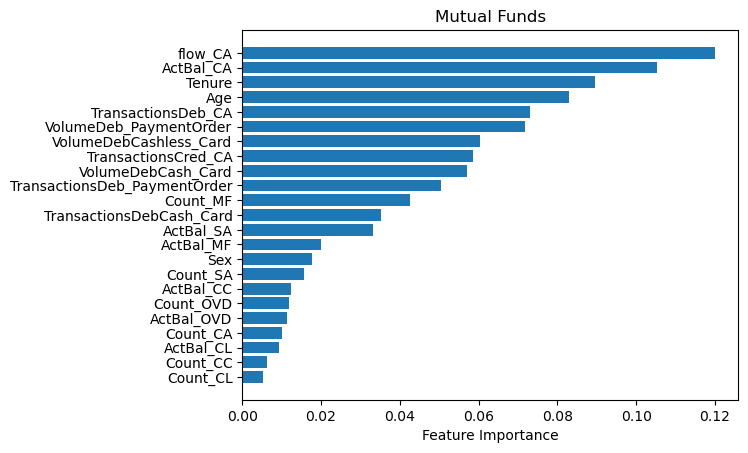

In [258]:
plt.title('Mutual Funds')
plt.barh(range(len(mf_indices)), mf_feature_importances[mf_indices], align='center')
plt.yticks(range(len(mf_indices)), [all_features[i] for i in mf_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of MF features according to RFE with 5-fold Cross-Validation

In [259]:
rfe_mf = RFECV(rfmf, cv=5, scoring="neg_mean_squared_error")
rfe_mf.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_MF"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [260]:
mf_selected_features = np.array(all_features)[rfe_mf.get_support()]
mf_selected_features

array(['Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'flow_CA',
       'TransactionsCred_CA', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDeb_CA', 'TransactionsDeb_PaymentOrder'], dtype='<U28')

#### Feature importances for CC

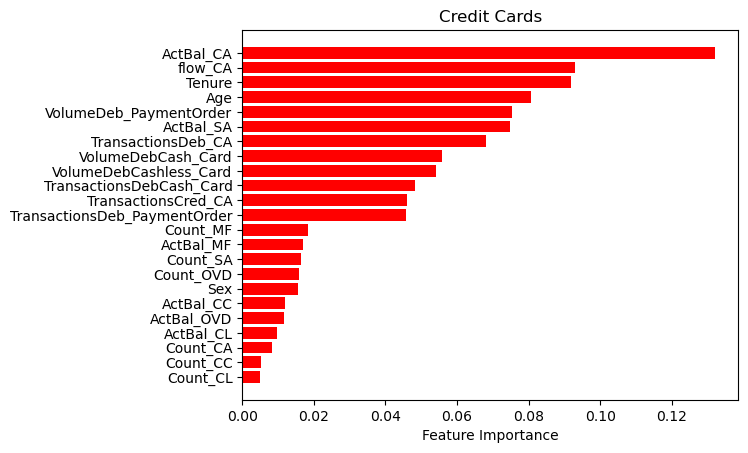

In [109]:
plt.title('Credit Cards')
plt.barh(range(len(cc_indices)), cc_feature_importances[cc_indices], color = "red", align='center')
plt.yticks(range(len(cc_indices)), [all_features[i] for i in cc_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of CC features according to RFE with 5-fold Cross-Validation

In [114]:
rfe_cc = RFECV(rfcc, cv=5, scoring="neg_mean_squared_error")
rfe_cc.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CC"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [115]:
cc_selected_features = np.array(all_features)[rfe_cc.get_support()]
cc_selected_features

array(['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD',
       'ActBal_CC', 'ActBal_CL', 'flow_CA', 'TransactionsCred_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDeb_PaymentOrder'],
      dtype='<U28')

#### Feature importances for CL

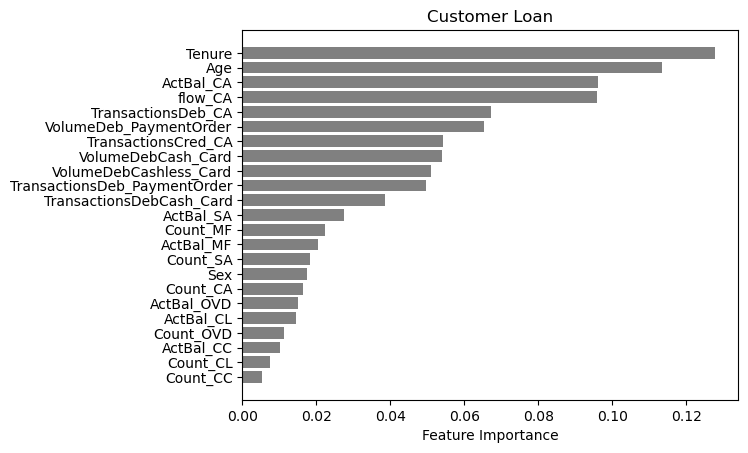

In [108]:
plt.title('Customer Loan')
plt.barh(range(len(cl_indices)), cl_feature_importances[cl_indices], color = "grey", align='center')
plt.yticks(range(len(cl_indices)), [all_features[i] for i in cl_indices], rotation = 0)
plt.xlabel('Feature Importance')
plt.show()

Select the best set of CL features according to RFE with 5-fold Cross-Validation

In [116]:
rfe_cl = RFECV(rfcl, cv=5, scoring="neg_mean_squared_error")
rfe_cl.fit(dmo_train_norm[all_features], dmo_train_norm[["Sale_CL"]].to_numpy().ravel())

RFECV(cv=5, estimator=RandomForestClassifier(n_estimators=500, random_state=50),
      scoring='neg_mean_squared_error')

In [117]:
cl_selected_features = np.array(all_features)[rfe_cl.get_support()]
cl_selected_features

array(['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'flow_CA',
       'TransactionsCred_CA', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
       'TransactionsDeb_CA', 'TransactionsDebCash_Card',
       'TransactionsDeb_PaymentOrder'], dtype='<U28')

The RF feature selection procedure results in different features selected for predicting each target sale variable.

#### Training datasets for three propensity models

In [261]:
dmo_train_mf = dmo_train_norm[['Sale_MF'] + list(mf_selected_features)]
dmo_train_cc = dmo_train_norm[['Sale_CC'] + list(cc_selected_features)]
dmo_train_cl = dmo_train_norm[['Sale_CL'] + list(cl_selected_features)]

In [262]:
dmo_train_mf.head()

,Sale_MF,Age,Tenure,Count_MF,ActBal_CA,ActBal_SA,flow_CA,TransactionsCred_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb_CA,TransactionsDeb_PaymentOrder
0,1.0,51,7,0.0,0.017799,0.000000,0.397446,23.0,0.010606,0.077823,0.003997,30.0,9.0
1,0.0,43,152,0.0,0.001478,0.034180,0.401192,3.0,0.013030,0.010558,0.000576,6.0,1.0
4,0.0,24,19,0.0,0.000057,0.000000,0.397845,2.0,0.015152,0.000000,0.000000,6.0,0.0
6,0.0,64,30,0.0,0.000000,0.000000,0.397675,21.0,0.010758,0.001919,0.000000,24.0,0.0
11,0.0,66,132,0.0,0.004722,0.000015,0.396935,3.0,0.014394,0.047677,0.005045,39.0,10.0


### 3. Check if the data is balanced

In [263]:
dmo_train_mf.Sale_MF.value_counts()

0.0    723
1.0    182
Name: Sale_MF, dtype: int64

In [264]:
dmo_train_cc.Sale_CC.value_counts()

0.0    674
1.0    231
Name: Sale_CC, dtype: int64

In [265]:
dmo_train_cl.Sale_CL.value_counts()

0.0    647
1.0    258
Name: Sale_CL, dtype: int64

The data are highly imbalanced: there are more clients who did not buy products compared to those who did. Downsampling is used to deal with the problem

#### Downsampling

In [148]:
# Subset the client who buy the products
dmo_train_mf_sale_yes = dmo_train_mf.loc[dmo_train_mf['Sale_MF'] == 1]
dmo_train_cc_sale_yes = dmo_train_cc.loc[dmo_train_cc['Sale_CC'] == 1]
dmo_train_cl_sale_yes = dmo_train_cl.loc[dmo_train_cl['Sale_CL'] == 1]

# Sample the clients who did not buy any product (the size is equal to ds with the clients with sales)
dmo_train_mf_sale_no = dmo_train_mf.loc[dmo_train_mf['Sale_MF'] == 0].sample(len(dmo_train_mf_sale_yes),
                                                                             random_state=10)

dmo_train_cc_sale_no = dmo_train_cc.loc[dmo_train_cc['Sale_CC'] == 0].sample(len(dmo_train_cc_sale_yes),
                                                                                      random_state=10)
dmo_train_cl_sale_no = dmo_train_cl.loc[dmo_train_cl['Sale_CL'] == 0].sample(len(dmo_train_cl_sale_yes),
                                                                                          random_state=10)

# Concatenate the dataframes

dmo_train_mf = pd.concat([dmo_train_mf_sale_yes, dmo_train_mf_sale_no])
dmo_train_cc = pd.concat([dmo_train_cc_sale_yes, dmo_train_cc_sale_no])
dmo_train_cl = pd.concat([dmo_train_cl_sale_yes, dmo_train_cl_sale_no])

#### Results after downsampling

In [149]:
dmo_train_mf.Sale_MF.value_counts()

1.0    182
0.0    182
Name: Sale_MF, dtype: int64

In [150]:
dmo_train_cc.Sale_CC.value_counts()

1.0    231
0.0    231
Name: Sale_CC, dtype: int64

In [151]:
dmo_train_cl.Sale_CL.value_counts()

1.0    258
0.0    258
Name: Sale_CL, dtype: int64

#### Stratify to ensure same distribution of both classes in training and validation

In [266]:
X_mf_f, X_cc_f, X_cl_f = dmo_train_norm[mf_selected_features], dmo_train_norm[cc_selected_features], dmo_train_norm[cl_selected_features]
Y_mf_f, Y_cc_f, Y_cl_f = dmo_train_norm['Sale_MF'], dmo_train_norm['Sale_CC'], dmo_train_norm['Sale_CL']

X_trainmf_f, X_valmf_f, Y_trainmf_f, Y_valmf_f = train_test_split(X_mf_f, Y_mf_f, test_size=0.2, random_state = 20, stratify=Y_mf_f)
X_traincc_f, X_valcc_f, Y_traincc_f, Y_valcc_f = train_test_split(X_cc_f, Y_cc_f, test_size=0.2, random_state = 20, stratify=Y_cc_f)
X_traincl_f, X_valcl_f, Y_traincl_f, Y_valcl_f = train_test_split(X_cl_f, Y_cl_f, test_size=0.2, random_state = 20, stratify=Y_cl_f)

# Split training datasets for training and validation - Downsampled dataset
X_mf, X_cc, X_cl = dmo_train_mf[mf_selected_features], dmo_train_cc[cc_selected_features], dmo_train_cl[cl_selected_features]
Y_mf, Y_cc, Y_cl = dmo_train_mf['Sale_MF'], dmo_train_cc['Sale_CC'], dmo_train_cl['Sale_CL']

X_trainmf, X_valmf, Y_trainmf, Y_valmf = train_test_split(X_mf, Y_mf, test_size=0.2, random_state = 20, stratify=Y_mf)
X_traincc, X_valcc, Y_traincc, Y_valcc = train_test_split(X_cc, Y_cc, test_size=0.2, random_state = 20, stratify=Y_cc)
X_traincl, X_valcl, Y_traincl, Y_valcl = train_test_split(X_cl, Y_cl, test_size=0.2, random_state = 20, stratify=Y_cl)

### 4. Propensity Models¶

The models chosen here are of type Mutli Layer Perceptron(MLP) neural network with 1 or more hidden layers. MLPs provide a good accuracy in many scenarios. The gradient descent algorithm is Adam and the loss function to be minimized by the neural network is binary cross entropy, suitable for this binary classification problem where we predict probability using a sigmoid function in the output layer. Due to the stochastic behaviour of the training algorithm, it is necessary to train the neural network several times until an acceptable accuracy is obtained.

In [156]:
np.random.seed(42)

In [153]:
def create_nn(X_data, nodes1, nodes2):
    # Input layer
    inputs = keras.layers.Input(shape=(X_data.shape[1],), name='input')

    # Dense layers
    layers_dense = keras.layers.Dense(nodes1, 'relu')(inputs)
    layers_dense = keras.layers.Dense(nodes2, 'relu')(layers_dense)

    # Output layer
    outputs = keras.layers.Dense(1, 'sigmoid')(layers_dense)

    return keras.Model(inputs=inputs, outputs=outputs, name="nn_model")

In [188]:
def train_validate_nn_model(X_train, Y_train, X_val, Y_val, nodes1 = 5, nodes2 = 10):
    # lr varied betwen 0.01 and 0.0005 to get best model
    # Number of deep layers varied between 1 and 3 to get the best model
    # Dropout and BatchNormalization did not improve results
    # Sale MF model
    
    model = create_nn(X_train, nodes1, nodes2)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.RootMeanSquaredError()])
    early_stopping_monitor = EarlyStopping(patience=50)
    history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=500,
                    validation_data=(X_val, Y_val),
                    verbose=False,
                    callbacks=[early_stopping_monitor])
    history_df = pd.DataFrame.from_dict(history.history)
    
    sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
    plt.xlabel("epochs")
    plt.ylabel("RMSE")
    
    return model

#### 4.1. Mutual Fund

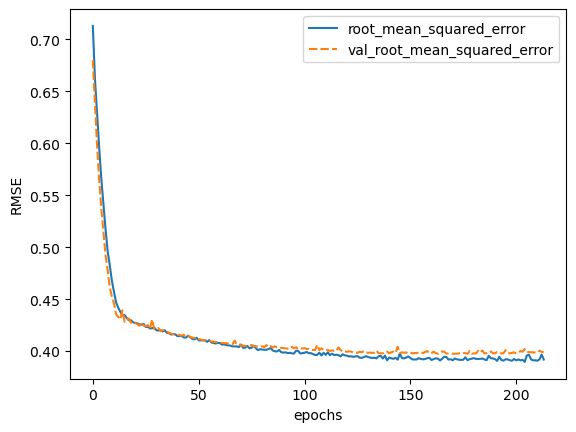

In [186]:
# Training and validation - Full dataset
sale_mf_f = train_validate_nn_model(X_trainmf_f, Y_trainmf_f, X_valmf_f, Y_valmf_f, 5, 10)

In [187]:
# AUC Score - Full dataset
roc_auc_score(Y_valmf_f, sale_mf_f.predict(X_valmf_f))

6/6 [==============================] - 0s 1ms/step


0.5162835249042146

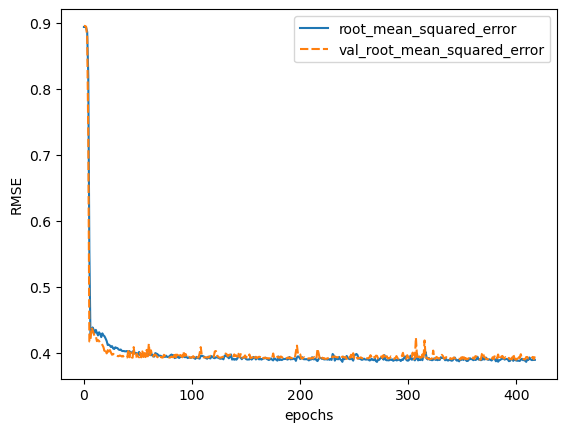

In [268]:
# Training and validation - Balanced dataset
sale_mf = train_validate_nn_model(X_trainmf, Y_trainmf, X_valmf, Y_valmf, 5, 10)

In [269]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valmf, sale_mf.predict(X_valmf))

6/6 [==============================] - 0s 1ms/step


0.5674329501915708

#### 4.2. Credit Cards

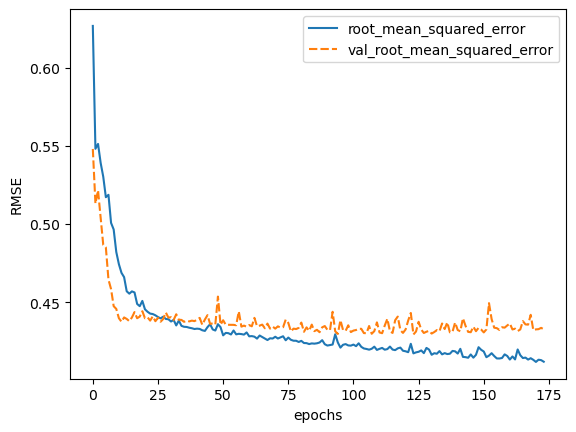

In [201]:
# Training and validation - Full dataset
sale_cc_f = train_validate_nn_model(X_traincc_f, Y_traincc_f, X_valcc_f, Y_valcc_f)

In [190]:
# AUC Score - Full dataset
roc_auc_score(Y_valcc_f, sale_cc_f.predict(X_valcc_f))

6/6 [==============================] - 0s 916us/step


0.566183574879227

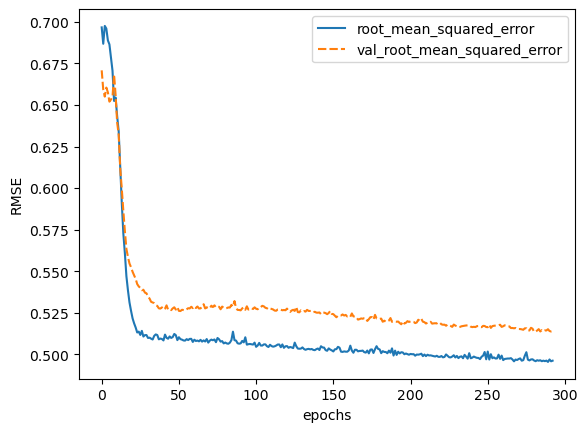

In [202]:
# Training and validation - Balanced dataset
sale_cc = train_validate_nn_model(X_traincc, Y_traincc, X_valcc, Y_valcc)

In [203]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcc, sale_cc.predict(X_valcc))

3/3 [==============================] - 0s 1ms/step


0.4366327474560592

The CC propensity modelling performed on full dataset gives a better accuracy and AUC score than the balanced dataset. The balanced dataset is likely too small to boost modelling performance.

#### 4.3. Consumer Loan

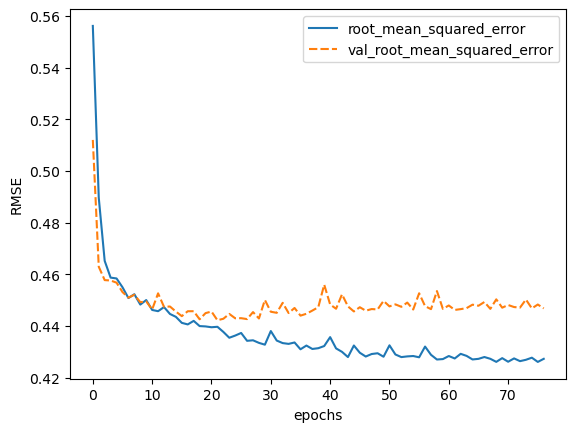

In [194]:
# Training and validation - Full dataset
sale_cl_f = train_validate_nn_model(X_traincl_f, Y_traincl_f, X_valcl_f, Y_valcl_f)

In [195]:
# AUC Score - Full dataset
roc_auc_score(Y_valcl_f, sale_cl_f.predict(X_valcl_f))

6/6 [==============================] - 0s 1ms/step


0.6043530113297555

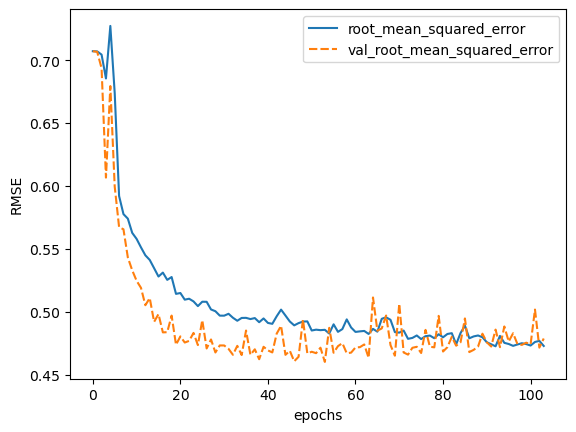

In [199]:
# Training and validation - Balanced dataset
sale_cl = train_validate_nn_model(X_traincl, Y_traincl, X_valcl, Y_valcl, 10, 10)

In [200]:
# AUC Score - Balanced dataset
roc_auc_score(Y_valcl, sale_cl.predict(X_valcl))

4/4 [==============================] - 0s 1ms/step


0.6405325443786982

The Consumer Loan (CL) propensity modelling performed on balanced dataset gives a better accuracy and AUC score than the full dataset. 

### 5. Propensity Prediction on Test Set

#### Test Data preparation

In [270]:
features_to_normalize = ['flow_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
                         'VolumeDeb_PaymentOrder', 'ActBal_CA', 'ActBal_SA',
                         'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']

min_max_scaler = preprocessing.MinMaxScaler()
dmo_test_norm = min_max_scaler.fit_transform(dmo_test[features_to_normalize])
dmo_test_norm = pd.DataFrame(dmo_test_norm, columns=features_to_normalize, 
                              index=dmo_test[features_to_normalize].index)

dmo_test_norm = pd.concat((dmo_test.drop(columns = features_to_normalize),
                           dmo_test_norm), 
                           axis = 1)

dmo_test_norm.describe()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,0.0,0.0,0.0,0.0,0.0,0.0,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,799.351082,0.527454,45.038270,103.469218,1.088186,0.277870,0.672213,0.256240,0.093178,0.116473,4.129784,13.154742,1.983361,4.600666,NaN,NaN,NaN,NaN,NaN,NaN,0.395374,0.025241,0.055348,0.009884,0.013536,0.018293,0.005295,0.019345,0.013326,0.020300
std,469.013036,0.502986,16.851316,63.715588,0.356665,0.536339,2.101756,0.436919,0.290924,0.427876,4.918312,13.046367,2.747676,5.246929,NaN,NaN,NaN,NaN,NaN,NaN,0.038733,0.056871,0.112308,0.047763,0.048460,0.079392,0.050738,0.094061,0.068949,0.092447
min,4.000000,-1.000000,19.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,381.000000,0.000000,31.000000,48.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.391715,0.000000,0.000000,0.000000,0.000250,0.000000,0.000000,0.000000,0.000000,0.000000
50%,796.000000,1.000000,42.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,1.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.393141,0.007353,0.003587,0.002362,0.002056,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1204.000000,1.000000,58.000000,152.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,19.000000,3.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.394667,0.034926,0.059654,0.007221,0.011210,0.000000,0.000000,0.000000,0.000000,0.000000
max,1614.000000,1.000000,97.000000,273.000000,4.000000,5.000000,28.000000,1.000000,1.000000,5.000000,37.000000,72.000000,17.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Prediction

In [271]:
# Predict Sale_MF, Sale_CC and Sale_CL probabilities for the test set, and fill the values into dmo_test dataframe
dmo_test_norm.loc[:, 'Sale_MF'] = sale_mf.predict(dmo_test_norm[mf_selected_features])
dmo_test_norm.loc[:, 'Sale_CC'] = sale_cc.predict(dmo_test_norm[cc_selected_features])
dmo_test_norm.loc[:, 'Sale_CL'] = sale_cl.predict(dmo_test_norm[cl_selected_features])
dmo_test_norm

19/19 [==============================] - 0s 811us/step


,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,TransactionsCred_CA,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,flow_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
2,4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,4.0,36.0,6.0,13.0,0.231984,0.475996,0.866184,NaN,NaN,NaN,0.367526,0.073529,0.212942,0.027161,9.324391e-03,0.000348,0.0,0.000000,0.315249,0.000000
3,5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,14.0,41.0,4.0,13.0,0.266429,0.495209,0.611468,NaN,NaN,NaN,0.377746,0.016176,0.336867,0.024621,3.120184e-02,0.036832,0.0,0.000000,0.000000,0.000000
5,7,0,55,227,1,0.0,0.0,0.0,0.0,0.0,2.0,10.0,1.0,1.0,0.188891,0.478742,0.329082,NaN,NaN,NaN,0.397301,0.001838,0.027993,0.000148,5.127090e-03,0.000000,0.0,0.000000,0.000000,0.000000
7,9,0,33,182,1,0.0,0.0,1.0,0.0,0.0,4.0,7.0,1.0,3.0,0.235294,0.559704,0.757102,NaN,NaN,NaN,0.393200,0.005515,0.000000,0.002362,2.973416e-03,0.000000,0.0,0.000000,0.000000,0.000000
8,10,0,29,48,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.212443,0.455708,0.369513,NaN,NaN,NaN,0.393128,0.000000,0.000000,0.000000,1.477241e-03,0.000532,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,1606,1,47,78,1,0.0,0.0,0.0,0.0,1.0,5.0,17.0,0.0,5.0,0.153114,0.481940,0.330447,NaN,NaN,NaN,0.403891,0.000000,0.052348,0.003039,1.379318e-02,0.000000,0.0,0.000000,0.000000,0.013022
1500,1609,1,31,111,1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.278311,0.422702,0.375327,NaN,NaN,NaN,0.392883,0.000000,0.000000,0.001286,1.205718e-03,0.000000,0.0,0.000000,0.000000,0.000000
1501,1610,0,48,92,1,0.0,0.0,1.0,0.0,0.0,5.0,18.0,3.0,7.0,0.133486,0.481679,0.385522,NaN,NaN,NaN,0.488702,0.020221,0.017767,0.002343,1.145524e-03,0.000000,0.0,0.335006,0.000000,0.000000
1502,1611,0,41,181,1,0.0,0.0,1.0,0.0,0.0,3.0,11.0,1.0,6.0,0.221508,0.478229,0.630053,NaN,NaN,NaN,0.392063,0.018382,0.013012,0.012321,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000


### 6. Revenue

The objective is to study the potential revenue which could be made from a marketing campaign targeting customers identified as having a high propensity/susceptibility.

<AxesSubplot:>

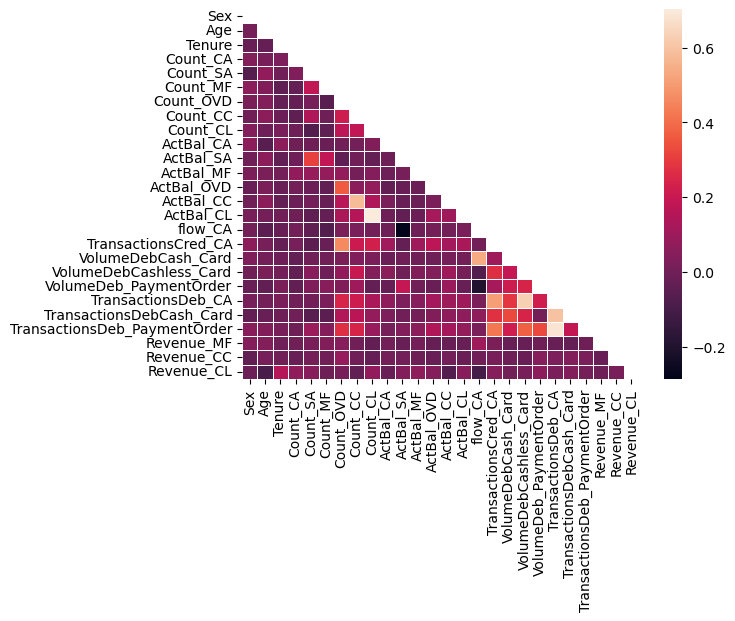

In [272]:
dmo_cor = dmo_train[soc_dem + products_act_bal + inflow_outflow + revenue].corr()

mask = np.triu(np.ones_like(dmo_cor))

sns.heatmap(dmo_cor, annot=False, linewidth=.5, mask=mask, xticklabels=True, yticklabels=True)

The revenue features don't correlate strongly with any features.

Remove Revenues with zeroes

In [273]:
revenue_mf = dmo_train['Revenue_MF'][dmo_train['Revenue_MF']>0]
revenue_cc = dmo_train['Revenue_CC'][dmo_train['Revenue_CC']>0]
revenue_cl = dmo_train['Revenue_CL'][dmo_train['Revenue_CL']>0]

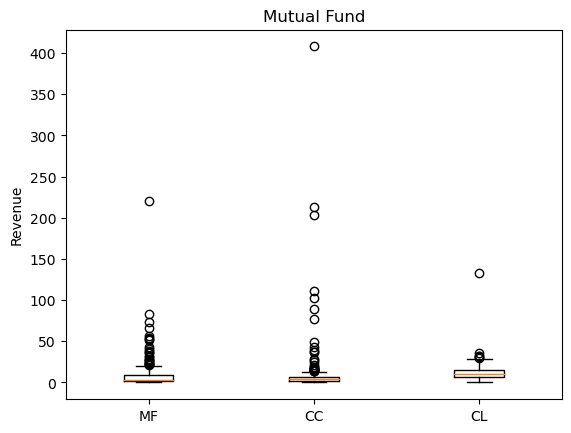

In [274]:
plt.boxplot([revenue_mf, revenue_cc, revenue_cl], labels = ["MF", "CC", "CL"])
plt.title("Mutual Fund")
plt.ylabel('Revenue')
plt.show()

#### Remove outlier

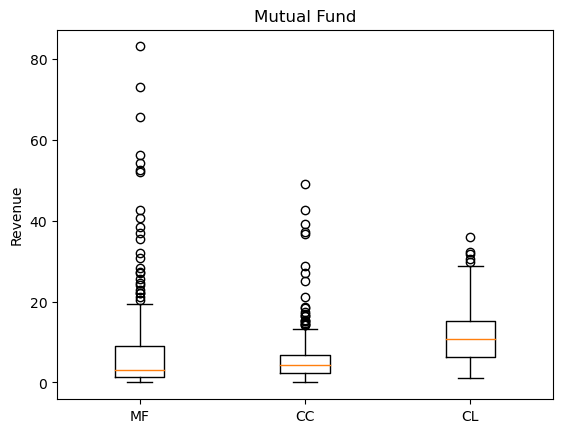

In [275]:
revenue_mf = revenue_mf[revenue_mf < 100]
revenue_cc = revenue_cc[revenue_cc < 50]
revenue_cl = revenue_cl[revenue_cl < 100]

plt.boxplot([revenue_mf, revenue_cc, revenue_cl], labels = ["MF", "CC", "CL"])
plt.title("Mutual Fund")
plt.ylabel('Revenue')
plt.show()

#### Revenue values for test data

In [276]:
[revenue_mf.mean(), revenue_cc.mean(), revenue_cl.mean()]

[8.646341752170482, 6.154907525510203, 11.430250138966093]

In [277]:
dmo_test_norm.loc[:, 'Revenue_MF'] = revenue_mf.mean()
dmo_test_norm.loc[:, 'Revenue_CC'] = revenue_cc.mean()
dmo_test_norm.loc[:, 'Revenue_CL'] = revenue_cl.mean()

final_features = ['Client', 'Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL']

final_df = dmo_test_norm[final_features]
final_df


,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
2,4,0.231984,0.475996,0.866184,8.646342,6.154908,11.43025
3,5,0.266429,0.495209,0.611468,8.646342,6.154908,11.43025
5,7,0.188891,0.478742,0.329082,8.646342,6.154908,11.43025
7,9,0.235294,0.559704,0.757102,8.646342,6.154908,11.43025
8,10,0.212443,0.455708,0.369513,8.646342,6.154908,11.43025
...,...,...,...,...,...,...,...
1497,1606,0.153114,0.481940,0.330447,8.646342,6.154908,11.43025
1500,1609,0.278311,0.422702,0.375327,8.646342,6.154908,11.43025
1501,1610,0.133486,0.481679,0.385522,8.646342,6.154908,11.43025
1502,1611,0.221508,0.478229,0.630053,8.646342,6.154908,11.43025


### 7. Results

#### 7.1. Which clients have higher propensity to buy consumer loan?

In [279]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_CL', ascending=False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_CL']].to_csv('../results/01_propensity_to_cl.csv', sep=';', header=True, index=False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
648,697,0.585972,0.335342,0.994161,8.646342,6.154908,11.43025
543,583,0.582502,0.372735,0.972856,8.646342,6.154908,11.43025
628,674,0.389913,0.638622,0.953962,8.646342,6.154908,11.43025
1362,1458,0.372590,0.526846,0.948212,8.646342,6.154908,11.43025
53,57,0.505729,0.492897,0.941082,8.646342,6.154908,11.43025


##### Important features for determining their propensity:

In [282]:
print(cl_selected_features)

['Age' 'Tenure' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDeb_PaymentOrder']


#### 7.2. Which clients have higher propensity to buy credit card?

In [284]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_CC', ascending=False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_CC']].to_csv('../results/02_propensity_to_cc.csv', sep=';', header=True, index=False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
141,150,0.212924,0.957241,0.665229,8.646342,6.154908,11.43025
1281,1373,0.347074,0.910671,0.394876,8.646342,6.154908,11.43025
806,866,0.334813,0.853340,0.830827,8.646342,6.154908,11.43025
1002,1077,0.215474,0.828844,0.805427,8.646342,6.154908,11.43025
403,431,0.285582,0.823319,0.671222,8.646342,6.154908,11.43025


##### Important features for determining their propensity:

In [282]:
print(cl_selected_features)

['Age' 'Tenure' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDeb_PaymentOrder']


#### 7.3. Which clients have higher propensity to buy mutual fund?

In [286]:
# Sort the output_data by Sale_CL in descending order
final_df = final_df.sort_values('Sale_MF', ascending=False)

# Save clients' propensity to buy a CL to csv 
final_df[['Client', 'Sale_MF']].to_csv('../results/03_propensity_to_mf.csv', sep=';', header=True, index=False)
final_df.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
365,389,0.818270,0.533837,0.357089,8.646342,6.154908,11.43025
704,756,0.808112,0.418207,0.931977,8.646342,6.154908,11.43025
1042,1119,0.780469,0.451645,0.894004,8.646342,6.154908,11.43025
725,779,0.774160,0.528347,0.583120,8.646342,6.154908,11.43025
623,668,0.666573,0.606602,0.597564,8.646342,6.154908,11.43025


##### Important features for determining their propensity:

In [287]:
print(mf_selected_features)

['Age' 'Tenure' 'Count_MF' 'ActBal_CA' 'ActBal_SA' 'flow_CA'
 'TransactionsCred_CA' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb_CA'
 'TransactionsDeb_PaymentOrder']


#### 7.4. Which clients are to be targeted with which offer?

We will create a composite score or expected revenue for each customer per offer by mutliplying the propensity and mean revenue expected.

Assumption : Higher revenue is generated from clients with higher propensity.

Then we will choose the highest expected revenue among the three and the corresponding offer as best offer for each client.

Finally, we will sort the clients by Expected Revenue in descending order to identify the top 100 customers to be targeted.

We will use the Expected Revenue and Best Offer columns as output.

97 clients to be targeted with Consumer Loan offer and 3 clients with Mutual Fund offer.*

In [288]:
final_df.loc[:, 'Score_MF'] = final_df.loc[:, 'Sale_MF'] * final_df.loc[:, 'Revenue_MF']
final_df.loc[:, 'Score_CC'] = final_df.loc[:, 'Sale_CC'] * final_df.loc[:, 'Revenue_CC']
final_df.loc[:, 'Score_CL'] = final_df.loc[:, 'Sale_CL'] * final_df.loc[:, 'Revenue_CL']

final_df

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL
365,389,0.818270,0.533837,0.357089,8.646342,6.154908,11.43025,7.075040,3.285718,4.081622
704,756,0.808112,0.418207,0.931977,8.646342,6.154908,11.43025,6.987213,2.574023,10.652733
1042,1119,0.780469,0.451645,0.894004,8.646342,6.154908,11.43025,6.748198,2.779836,10.218693
725,779,0.774160,0.528347,0.583120,8.646342,6.154908,11.43025,6.693655,3.251930,6.665211
623,668,0.666573,0.606602,0.597564,8.646342,6.154908,11.43025,5.763414,3.733579,6.830307
...,...,...,...,...,...,...,...,...,...,...
159,169,0.075256,0.536608,0.268232,8.646342,6.154908,11.43025,0.650688,3.302774,3.065960
1353,1449,0.075236,0.510858,0.420795,8.646342,6.154908,11.43025,0.650519,3.144286,4.809788
1249,1339,0.074867,0.544787,0.228846,8.646342,6.154908,11.43025,0.647323,3.353115,2.615772
1055,1132,0.070326,0.564928,0.270925,8.646342,6.154908,11.43025,0.608060,3.477078,3.096737


In [289]:
def compare(row):
    if row['Score_MF'] > row['Score_CC'] and row['Score_MF'] > row['Score_CL']:    # Best offer for this customer is MF
        result = [row['Score_MF'], 'Mutual Fund']
    elif row['Score_CC'] > row['Score_MF'] and row['Score_CC'] > row['Score_CL']:  # Best offer for this customer is CC
        result = [row['Score_CC'], 'Credit Card']
    elif row['Score_CL'] > row['Score_MF'] and row['Score_CL'] > row['Score_CC']:  # Best offer for this customer is CL
        result = [row['Score_CL'], 'Consumer Loan']
    return result

final_df.loc[:,'Expected_Revenue'] = final_df.apply(lambda row:compare(row)[0], axis=1)
final_df.loc[:,'Best_Offer'] = final_df.apply(lambda row:compare(row)[1], axis=1)
final_df

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Score_MF,Score_CC,Score_CL,Expected_Revenue,Best_Offer
365,389,0.818270,0.533837,0.357089,8.646342,6.154908,11.43025,7.075040,3.285718,4.081622,7.075040,Mutual Fund
704,756,0.808112,0.418207,0.931977,8.646342,6.154908,11.43025,6.987213,2.574023,10.652733,10.652733,Consumer Loan
1042,1119,0.780469,0.451645,0.894004,8.646342,6.154908,11.43025,6.748198,2.779836,10.218693,10.218693,Consumer Loan
725,779,0.774160,0.528347,0.583120,8.646342,6.154908,11.43025,6.693655,3.251930,6.665211,6.693655,Mutual Fund
623,668,0.666573,0.606602,0.597564,8.646342,6.154908,11.43025,5.763414,3.733579,6.830307,6.830307,Consumer Loan
...,...,...,...,...,...,...,...,...,...,...,...,...
159,169,0.075256,0.536608,0.268232,8.646342,6.154908,11.43025,0.650688,3.302774,3.065960,3.302774,Credit Card
1353,1449,0.075236,0.510858,0.420795,8.646342,6.154908,11.43025,0.650519,3.144286,4.809788,4.809788,Consumer Loan
1249,1339,0.074867,0.544787,0.228846,8.646342,6.154908,11.43025,0.647323,3.353115,2.615772,3.353115,Credit Card
1055,1132,0.070326,0.564928,0.270925,8.646342,6.154908,11.43025,0.608060,3.477078,3.096737,3.477078,Credit Card


In [290]:
final_df = final_df.sort_values('Expected_Revenue', ascending=False)
target_clients = final_df.loc[:,['Client', 'Expected_Revenue', 'Best_Offer']].head(100)
target_clients['Best_Offer'].value_counts()

Consumer Loan    100
Name: Best_Offer, dtype: int64

In [291]:
# Save output to csv file
target_clients.to_csv('../results/04_target_clients.csv', sep=';', header=True, index=False)
target_clients

,Client,Expected_Revenue,Best_Offer
648,697,11.363508,Consumer Loan
543,583,11.119989,Consumer Loan
628,674,10.904027,Consumer Loan
1362,1458,10.838304,Consumer Loan
53,57,10.756805,Consumer Loan
...,...,...,...
349,373,7.718765,Consumer Loan
1251,1341,7.705815,Consumer Loan
64,70,7.689966,Consumer Loan
403,431,7.672236,Consumer Loan


#### 7.5. What would be the expected revenue?

In [294]:
target_clients['Expected_Revenue'].sum()

938.6886766456537